### Re-State Our Goal
*Goal:* We want to use Shaggy's dataset to train a male/female butterfly classifier. And we need to describe the dataset work that Shaggy's done.

### State Our Assumptions About the Dataset
When we started, our assumptions were:
- Shaggy's dataset is derived from Kydoimos
- No changes have been made to the image data content
- No images have been added or removed
- Each component of Shaggy's dataset can be linked to its corresponding component into the source dataset (provenance is intact)
- Test/train splits are done appropriately

Apparently, some, or all of these assumptions weren't accurate.

### Make an Intermediate Goal
*Goal:* We want to see if we can re-link Shaggy's work to the original dataset.</br>
 To test which of our assumptions are off, let's do the following:
1. Download the original/upstream/source dataset (Kydoimos)
2. Load Shaggy's dataset
3. Run MD5 checksums on all images in Kydoimos and Shaggy's dataset
4. Merge on MD5

In [3]:
# All imports
import pandas as pd
from datasets import load_dataset
import os
import hashlib
import io
from io import BytesIO
from PIL import Image, UnidentifiedImageError
from PIL.TiffTags import TAGS
import numpy as np

## 1. Download the original/upstream/source dataset (Kydoimos) 

In [4]:
dataset_path = "johnbradley/Kydoimos"
kydoimos = load_dataset(dataset_path)

Resolving data files:   0%|          | 0/111 [00:00<?, ?it/s]

### Explore the upstream dataset

In [5]:
kydoimos

DatasetDict({
    train: Dataset({
        features: ['image', 'id', 'NHM specimen number', 'View', 'Species', 'Subspecies', 'Sex', 'Type Status'],
        num_rows: 110
    })
})

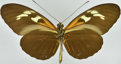

In [6]:
kydoimos['train']['image'][1]

In [7]:
print(kydoimos['train']['image'][1])

<PIL.TiffImagePlugin.TiffImageFile image mode=RGB size=121x64 at 0x1C9B3E86C90>


### Load the upstream dataset into a Pandas dataframe for simpler exploration

In [8]:
kydoimos_df = pd.DataFrame(kydoimos['train'])

In [9]:
kydoimos_df.head(3)

,image,id,NHM specimen number,View,Species,Subspecies,Sex,Type Status
0,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000000,10428329,dorsal,melpomene,thelxiopeia,male,None
1,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000001,10428329,ventral,melpomene,thelxiopeia,male,None
2,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000002,10428331,dorsal,melpomene,thelxiopeia,female,None


In [10]:
kydoimos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   image                110 non-null    object
 1   id                   110 non-null    object
 2   NHM specimen number  110 non-null    int64 
 3   View                 110 non-null    object
 4   Species              110 non-null    object
 5   Subspecies           110 non-null    object
 6   Sex                  110 non-null    object
 7   Type Status          2 non-null      object
dtypes: int64(1), object(7)
memory usage: 7.0+ KB


In [12]:
kydoimos_df.drop(columns=['image']).nunique()

id                     110
NHM specimen number     38
View                     4
Species                  2
Subspecies               6
Sex                      4
Type Status              1
dtype: int64

## 2. Load Shaggy's dataset

In [13]:
shaggy_dir = "../Shaggy/"
shaggy_df = pd.read_csv(os.path.join(shaggy_dir, 'metadata.csv'), encoding='utf-8', low_memory=False)

In [15]:
shaggy_df.head(3)

,file_name,Sex,split,rel_file_path
0,images/melpomene_26.tif,female,train,../Shaggy/images/melpomene_26.tif
1,images/melpomene_16.tif,female,train,../Shaggy/images/melpomene_16.tif
2,images/melpomene_18.tif,female,train,../Shaggy/images/melpomene_18.tif


In [14]:
shaggy_df['rel_file_path'] = shaggy_dir + shaggy_df['file_name']

In [17]:
shaggy_df.nunique()

file_name        108
Sex                4
split              2
rel_file_path    108
dtype: int64

## 3. Run MD5 checksums on all images in Kydoimos and Shaggy's dataset

In [22]:
data1 = b'abcdefg'
data2 = b'abcdefG'

hash = hashlib.md5()
hash.update(data1)
checksum = hash.hexdigest()
print(checksum)

hash = hashlib.md5()
hash.update(data2)
checksum = hash.hexdigest()
print(checksum)

7ac66c0f148de9519b8bd264312c4d64
b75cf09fe732203cf2389bea4c646c27


In [23]:
def file_md5_checksum(file_path):
    hash = hashlib.md5()
    with open(file_path, "rb") as f:
        file_bytes = f.read()
        hash.update(file_bytes)
    checksum = hash.hexdigest()
    return checksum

def pil_md5_checksum(image):
    hash = hashlib.md5()
    buffer = BytesIO()
    image.save(buffer, format=image.format)
    hash.update(buffer.getvalue())
    checksum = hash.hexdigest()
    return checksum

In [26]:
shaggy_df['md5'] = shaggy_df['rel_file_path'].apply(file_md5_checksum)
kydoimos_df['md5'] = kydoimos_df['image'].apply(pil_md5_checksum)

In [28]:
kydoimos_df.drop(columns=['image']).to_csv('kydoimos.csv', index=False)

In [31]:
kydoimos_df.head(3)

,image,id,NHM specimen number,View,Species,Subspecies,Sex,Type Status,md5
0,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000000,10428329,dorsal,melpomene,thelxiopeia,male,None,bfe69135302b78cef66df623ddb5befd
1,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000001,10428329,ventral,melpomene,thelxiopeia,male,None,c860654219c233d353277b049610bae4
2,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000002,10428331,dorsal,melpomene,thelxiopeia,female,None,e721585817681ef60e5d0ab81ca00cfd


In [33]:
merge_df = pd.merge(shaggy_df, kydoimos_df, on='md5', how='inner')
merge_df.head(3)

,file_name,Sex_x,split,rel_file_path,md5,image,id,NHM specimen number,View,Species,Subspecies,Sex_y,Type Status


## 4. Merge the datasets on MD5 to link them together

### Zoinks

In [45]:
shaggy_df['image'] = shaggy_df['rel_file_path'].apply(lambda x: Image.open(x))

In [46]:
img = Image.open('../Shaggy/images/amalfreda_0.tif')
img

C:\Users\thompson.4509\AppData\Local\miniconda3\envs\data-workshop-2024\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


UnidentifiedImageError: cannot identify image file 'C:\\Users\\thompson.4509\\projects\\all-hands-2024\\data-workshop-AH-2024\\Shaggy\\images\\amalfreda_0.tif'

In [41]:
def verify_image(image_path):
    try: 
        with Image.open(image_path) as img:
            img.verify()
        return True
    except Exception as e:
        print(f"Zoinks, corrupt image: {image_path}, error: {e}")
        return False

In [44]:
shaggy_df['valid_image'] = shaggy_df['rel_file_path'].apply(verify_image)

In [43]:
shaggy_df = shaggy_df[shaggy_df['valid_image']]

In [48]:
shaggy_df['pil_md5'] = shaggy_df['image'].apply(pil_md5_checksum)

In [49]:
shaggy_df.head(3)

,file_name,Sex,split,rel_file_path,md5,valid_image,image,pil_md5
0,images/melpomene_26.tif,female,train,../Shaggy/images/melpomene_26.tif,06dce3c46bdba7ed28cde331a13037bf,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,bc18e0e7467c27c337dcd7ffcc6c4ace
1,images/melpomene_16.tif,female,train,../Shaggy/images/melpomene_16.tif,6b8721ab120e7891ee32bbd5292a81f1,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,cffe8c60e88431f964e02d42a2faae53
2,images/melpomene_18.tif,female,train,../Shaggy/images/melpomene_18.tif,114f5cd45d57fca44f0474645ef13033,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,259b2e20477d01fad3625a19e1b42e1b


In [50]:
merge_df = pd.merge(shaggy_df, kydoimos_df, left_on='pil_md5', right_on='md5', how='inner', suffixes = ("_shaggy", "_kydoimos"))
merge_df

,file_name,Sex_shaggy,split,rel_file_path,md5_shaggy,valid_image,image_shaggy,pil_md5,image_kydoimos,id,NHM specimen number,View,Species,Subspecies,Sex_kydoimos,Type Status,md5_kydoimos
0,images/melpomene_26.tif,female,train,../Shaggy/images/melpomene_26.tif,06dce3c46bdba7ed28cde331a13037bf,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,bc18e0e7467c27c337dcd7ffcc6c4ace,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000026,10428375,dorsal,melpomene,melpomene,female,None,bc18e0e7467c27c337dcd7ffcc6c4ace
1,images/melpomene_26.tif,female,train,../Shaggy/images/melpomene_26.tif,06dce3c46bdba7ed28cde331a13037bf,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,bc18e0e7467c27c337dcd7ffcc6c4ace,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000102,10428375,dorsal,melpomene,melpomene,female,None,bc18e0e7467c27c337dcd7ffcc6c4ace
2,images/melpomene_16.tif,female,train,../Shaggy/images/melpomene_16.tif,6b8721ab120e7891ee32bbd5292a81f1,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,cffe8c60e88431f964e02d42a2faae53,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000016,10428369,dorsal,melpomene,melpomene,female,None,cffe8c60e88431f964e02d42a2faae53
3,images/melpomene_16.tif,female,train,../Shaggy/images/melpomene_16.tif,6b8721ab120e7891ee32bbd5292a81f1,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,cffe8c60e88431f964e02d42a2faae53,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000092,10428369,dorsal,melpomene,melpomene,female,None,cffe8c60e88431f964e02d42a2faae53
4,images/melpomene_18.tif,female,train,../Shaggy/images/melpomene_18.tif,114f5cd45d57fca44f0474645ef13033,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,259b2e20477d01fad3625a19e1b42e1b,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000018,10428370,dorsal,melpomene,melpomene,female,None,259b2e20477d01fad3625a19e1b42e1b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,images/thelxiopeia_9.tif,male,test,../Shaggy/images/thelxiopeia_9.tif,3aa33ba62b16ca0ee4dc7d18fe8903ca,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,a3087cad4e713f385121af6ca92eb045,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000085,10428334,ventral,melpomene,thelxiopeia,male,None,a3087cad4e713f385121af6ca92eb045
168,images/etylus_8.tif,Female,test,../Shaggy/images/etylus_8.tif,0484bcec9638436a1ac64b396f988733,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,4f54ae93cb60136306196c061c0c3982,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000074,10429061,dorsal,erato,etylus,Female,None,4f54ae93cb60136306196c061c0c3982
169,images/thelxiopeia_12.tif,female,test,../Shaggy/images/thelxiopeia_12.tif,e6f96641117fb0c1689d2dd1cce8f275,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,503ef2599a12e0e8389f4cac0c5fef54,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000012,10428336,dorsal,melpomene,thelxiopeia,female,None,503ef2599a12e0e8389f4cac0c5fef54
170,images/thelxiopeia_12.tif,female,test,../Shaggy/images/thelxiopeia_12.tif,e6f96641117fb0c1689d2dd1cce8f275,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,503ef2599a12e0e8389f4cac0c5fef54,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000088,10428336,dorsal,melpomene,thelxiopeia,female,None,503ef2599a12e0e8389f4cac0c5fef54


In [51]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   file_name            172 non-null    object
 1   Sex_shaggy           172 non-null    object
 2   split                172 non-null    object
 3   rel_file_path        172 non-null    object
 4   md5_shaggy           172 non-null    object
 5   valid_image          172 non-null    bool  
 6   image_shaggy         172 non-null    object
 7   pil_md5              172 non-null    object
 8   image_kydoimos       172 non-null    object
 9   id                   172 non-null    object
 10  NHM specimen number  172 non-null    int64 
 11  View                 172 non-null    object
 12  Species              172 non-null    object
 13  Subspecies           172 non-null    object
 14  Sex_kydoimos         172 non-null    object
 15  Type Status          0 non-null      object
 16  md5_kydo

In [52]:
merge_df['file_name'].nunique()

106

In [53]:
shaggy_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107 entries, 0 to 107
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   file_name      107 non-null    object
 1   Sex            107 non-null    object
 2   split          107 non-null    object
 3   rel_file_path  107 non-null    object
 4   md5            107 non-null    object
 5   valid_image    107 non-null    bool  
 6   image          107 non-null    object
 7   pil_md5        107 non-null    object
dtypes: bool(1), object(7)
memory usage: 6.8+ KB


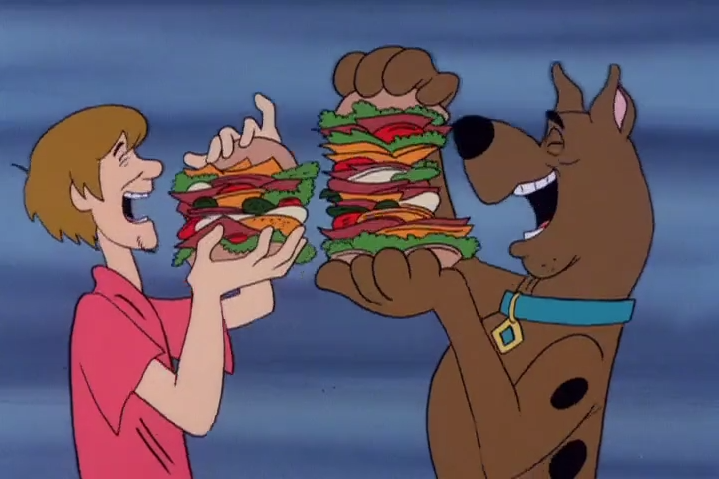

83    None
Name: image, dtype: object

In [54]:
from IPython.display import display
matches = shaggy_df.loc[~shaggy_df['pil_md5'].isin(merge_df['pil_md5']), :]
matches['image'].apply(display)

In [55]:
merge_df.head()

,file_name,Sex_shaggy,split,rel_file_path,md5_shaggy,valid_image,image_shaggy,pil_md5,image_kydoimos,id,NHM specimen number,View,Species,Subspecies,Sex_kydoimos,Type Status,md5_kydoimos
0,images/melpomene_26.tif,female,train,../Shaggy/images/melpomene_26.tif,06dce3c46bdba7ed28cde331a13037bf,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,bc18e0e7467c27c337dcd7ffcc6c4ace,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000026,10428375,dorsal,melpomene,melpomene,female,None,bc18e0e7467c27c337dcd7ffcc6c4ace
1,images/melpomene_26.tif,female,train,../Shaggy/images/melpomene_26.tif,06dce3c46bdba7ed28cde331a13037bf,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,bc18e0e7467c27c337dcd7ffcc6c4ace,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000102,10428375,dorsal,melpomene,melpomene,female,None,bc18e0e7467c27c337dcd7ffcc6c4ace
2,images/melpomene_16.tif,female,train,../Shaggy/images/melpomene_16.tif,6b8721ab120e7891ee32bbd5292a81f1,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,cffe8c60e88431f964e02d42a2faae53,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000016,10428369,dorsal,melpomene,melpomene,female,None,cffe8c60e88431f964e02d42a2faae53
3,images/melpomene_16.tif,female,train,../Shaggy/images/melpomene_16.tif,6b8721ab120e7891ee32bbd5292a81f1,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,cffe8c60e88431f964e02d42a2faae53,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000092,10428369,dorsal,melpomene,melpomene,female,None,cffe8c60e88431f964e02d42a2faae53
4,images/melpomene_18.tif,female,train,../Shaggy/images/melpomene_18.tif,114f5cd45d57fca44f0474645ef13033,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,259b2e20477d01fad3625a19e1b42e1b,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000018,10428370,dorsal,melpomene,melpomene,female,None,259b2e20477d01fad3625a19e1b42e1b
